# engine

> A scalar valued Autograd engine

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp engine

In [ ]:
#| hide
#| export
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
%matplotlib inline

In [ ]:
#| hide
class Value:
    '''stores a single scalar value and its gradient'''
    def __init__(self, 
                 data,# a scalar value
                 _children=(),# The children of this value
                 _op='',# The operation that created this value
                 label=''):
        self.data, self._prev, self._op = data, set(_children), _op
        self.label = label 
        self.grad = 0 # derivative of the Loss with respect to this value
        
    def __add__(self, other):
        out = Value(self.data + other.data, (self,other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other),'*')
        return out
    
    def __repr__(self):
        return f'Value(data={self.data})'

In [ ]:
#|hide
a = Value(2., label='a')
a

Value(data=2.0)

In [ ]:
#|hide
b = Value(-3, label='b')
a+b

Value(data=-1.0)

In [ ]:
#|hide
c = Value(10., label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d

Value(data=4.0)

In [ ]:
#|hide
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [ ]:
#|hide
d._op

'+'

In [ ]:
#|hide
f = Value(-2.); f.label='f'
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [ ]:
#|hide

# manual gradients
L.grad=1
f.grad=d.data
d.grad=f.data
c.grad = d.grad
e.grad = d.grad
b.grad=e.grad * a.data
a.grad=e.grad * b.data

# nudge leaf nodes that we control
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass to evaluate L
e = a*b
d = e + c
L = d*f
L

Value(data=-7.286496)

#|hide

Hooray, $L$ increased from $-8$ to $-7.28$!

In [ ]:
#|hide
del Value

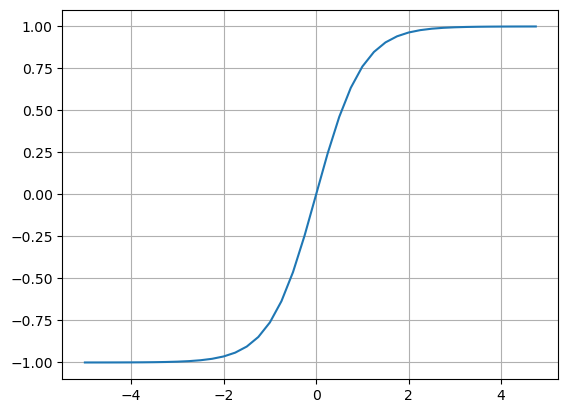

In [ ]:
#|hide
# A squashing function (a.k.a as an activation function)
xs = np.arange(-5,5,0.25)
ys = np.tanh(xs)
plt.plot(xs, ys); plt.grid()

#|hide

Now $\tanh(x) = \frac{e^{2x}+1}{e^{2x}+1}$ so at this point we will update our `Value` so we can do exponentiation and division.

In [ ]:
#|hide
# add tanh
# Add ability to chain the local gradient to the incoming gradient
class Value:
    '''stores a single scalar value and its gradient'''
    def __init__(self, 
                 data,# a scalar value
                 _children=(),# The children of this value
                 _op='',# The operation (+,-,* or tanh) that created this value
                 label=''):
        self.data, self._prev, self._op = data, set(_children), _op
        self.label = label 
        self.grad = 0 # derivative of the Loss with respect to this value
        self._backward = lambda: None #function to chain the incoming gradient with the local gradient
        
    def __add__(self, other):
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other),'*')
                
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1.)/(math.exp(2*x)+1.)
        out = Value(t,(self,),'tanh',)
        
                
        def _backward():
            self.grad = (1.0 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def __repr__(self):
        return f'Value(data={self.data})'

#|hide

Back to our motivating example again.

In [ ]:
#|hide
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881375870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b; n.label='n'

o= n.tanh(); o.label='o'

#|hide  

Backprop pass 2

In [ ]:
#|hide
o.grad = 1.0 #initialize otherwise all gradients will be stuck at zero
o._backward();
n._backward();
# view_dot(o)

In [ ]:
#|hide
x1w1x2w2._backward();
b._backward();#Not needed since this is a leaf node and will have a _backward that is lambda: None
# view_dot(o)

In [ ]:
#|hide
x1w1._backward();
w1._backward();x1._backward();
# view_dot(o)

In [ ]:
#|hide
x2w2._backward();
w2._backward();x2._backward();

In [ ]:
#|hide
# view_dot(o)

#|hide
Now let's automate calling the \_backward in the correct order. For this we will use topological sorting which involves laying out the nodes of a graph such that all the edges only go in one direction.

In [ ]:
#|hide
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v) 
        for child in v._prev:
            build_topo(child)
        topo.append(v) 
build_topo(o)
topo

[Value(data=6.881375870195432),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813758701954324),
 Value(data=0.7071079227726492)]

In [ ]:
#|hide
[v.label for v in topo]

['b', 'x2', 'w2', 'x2w2', 'w1', 'x1', 'x1w1', 'x1w1+x2w2', 'n', 'o']

#|hide
Let's recreate the network.

In [ ]:
#|hide
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881375870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b; n.label='n'

o= n.tanh(); o.label='o'

In [ ]:
#|hide
o.grad = 1.0

for node in reversed(topo): 
    node._backward()

In [ ]:
#|hide
del Value

In [ ]:
#|hide
# Add ability to call backward in an automated fashion
class Value:
    '''stores a single scalar value and its gradient'''
    def __init__(self, 
                 data,# a scalar value
                 _children=(),# The children of this value
                 _op='',# The operation (+,-,* or tanh) that created this value
                 label=''):
        self.data, self._prev, self._op = data, set(_children), _op
        self.label = label 
        self.grad = 0 # derivative of the Loss with respect to this value
        self._backward = lambda: None #function to chain the incoming gradient with the local gradient
        
    def __add__(self, other):
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self,other),'*')
                
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1.)/(math.exp(2*x)+1.)
        out = Value(t,(self,),'tanh',)
        
                
        def _backward():
            self.grad = (1.0 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v) 
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo): 
            node._backward()
        
    
    def __repr__(self):
        return f'Value(data={self.data})'

In [ ]:
#|hide
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881375870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b; n.label='n'

o= n.tanh(); o.label='o'

#|hide

Backward Pass

Automatic gradient computation.

In [ ]:
#|hide
o.backward()

In [ ]:
#|hide
o.grad, n.grad, x1w1x2w2.grad, x1w1.grad, x2w2.grad, x1.grad, w1.grad, x2.grad, w2.grad,

(1.0,
 0.49999838555214915,
 0.49999838555214915,
 0.49999838555214915,
 0.49999838555214915,
 -1.4999951566564476,
 0.9999967711042983,
 0.49999838555214915,
 0.0)

#|hide

We have a bug. This bug shows up anytime a variable shows up more than once.

We know that the derivative of $a^2$ with respect to $a$ is $2*a$. We see that the answer from our code is just $a$.

In [ ]:
#|hide
a = Value(-2., label='a')
b = a*a; b.label='b'
b.backward()

In [ ]:
#|hide
a.grad

-2.0

#|hide

Another example. Here we see that the last gradient to flow back overrides the other one. 

We have $\frac{\partial f}{\partial a} = \frac{\partial f}{\partial e}*\frac{\partial e}{\partial a} + \frac{\partial f}{\partial d}*\frac{\partial d}{\partial a} = -6*1+1*3=-3$ and $\frac{\partial f}{\partial b} = \frac{\partial f}{\partial e}*\frac{\partial e}{\partial b} + \frac{\partial f}{\partial d}*\frac{\partial d}{\partial b} = -6*1+1*-2=-8$

The way to think here is that any node in the graph needs to multiply its measure of how it influences its local output with the measure of how that local output affects the final loss. If it has multiple outputs then it needs to sum over the previous quantity for each output that it has.

So $a$ would say 
* multiply how I affect $d$ multiply with how $d$ affects $f$
* multiply how I affect $e$ with how $e$ affects $f$
* sum up the previous two estimates.

In [ ]:
#|hide
a = Value(-2., label='a')
b = Value(3., label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

In [ ]:
#|hide
f.backward()

In [ ]:
#|hide
# incorrect!
a.grad

3.0

In [ ]:
#|hide
# incorrect!
b.grad

-2.0

#|hide

Also at this point if we run the following:

```a = Value(2.);a+1``` or ```a = Value(2.);a*1```

an `AttributeError: 'int' object has no attribute 'data'` will be raised. 

This is because $1$ is a constant and not a value object.

Similarly if we run ```a = Value(2.);1+a``` or ```a = Value(2.);1*a```

an `TypeError: unsupported operand type(s) for *: 'int' and 'Value'` is raised.

#|hide

So the solution is that in the `Value` class we need to accumulate gradients instead of setting them.

In [ ]:
#|hide
del Value

In [ ]:
#|export
# accumulate gradients
# allow adding and multiplying constants
# exponentiate, power, divide, subtract
class Value:
    '''stores a single scalar value and its gradient'''
    def __init__(self, 
                 data,# a scalar value
                 _children=(),# The children of this value
                 _op='',# The operation (+,-,* or tanh) that created this value
                 label=''):
        self.data, self._prev, self._op = data, set(_children), _op
        self.label = label 
        self.grad = 0 # derivative of the Loss with respect to this value
        self._backward = lambda: None #function to chain the incoming gradient with the local gradient
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other): #if Python cannot do other + self
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')
                
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self,other): # self^{other}
        assert isinstance(other, (int,float)), "only support int/float powers for now" 
        t = self.data ** other 
        out = Value(t, (self,),f'**{other}')
        
        def _backward():
            self.grad += (other * ( self.data ** (other-1) )) * out.grad
        out._backward = _backward
                
        return out
            
    def __rmul__(self, other): #if Python cannot do other times self
        return self * other
    
    def __truediv__(self, other): #self/other
        return self * (other**-1)
    
    def __neg__(self): #-self
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1.)/(math.exp(2*x)+1.)
        out = Value(t,(self,),'tanh',)
              
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t,(self,),'exp',)
        
        def _backward():
            self.grad += t * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v) 
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo): 
            node._backward()
        
    
    def __repr__(self):
        return f'Value(data={self.data})'

In [ ]:
a = Value(3., label='a')
b = a+a; b.label='b'

b.backward()

assert a.grad == 2 

In [ ]:
a = Value(-2., label='a')
b = Value(3., label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()

a.grad, b.grad

(-3.0, -8.0)

In [ ]:
a = Value(2.)
a+1

Value(data=3.0)

In [ ]:
#|hide
a = Value(2.)
1*a

Value(data=2.0)

In [ ]:
#|hide
a = Value(1.)
a.exp()

Value(data=2.718281828459045)

In [ ]:
#|hide
a = Value(2.)
b = Value(4.)
a/b

Value(data=0.5)

In [ ]:
#|hide
b = Value(4.)
b**(.5)

Value(data=2.0)

In [ ]:
#|hide
a = Value(2.)
b = Value(4.)
a-b

Value(data=-2.0)

In [ ]:
#|hide
a = Value(2.)
b = Value(4.)
a+b

Value(data=6.0)

In [ ]:
#|hide
del Value

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()